In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


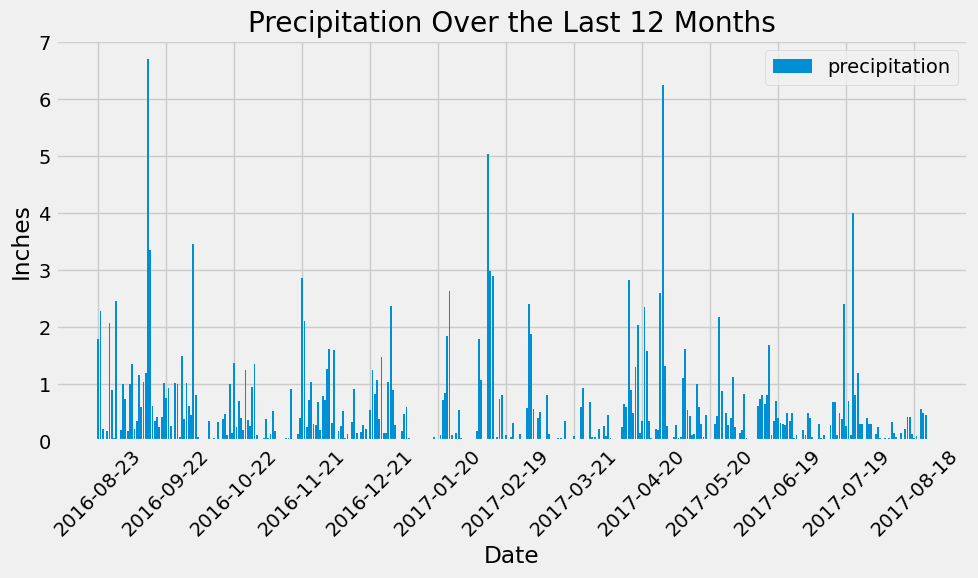

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
most_recent_date = most_recent_date[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
one_year_ago = most_recent_date - timedelta(days=365)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data

# Set 'Date' column as the DataFrame index and convert it to a datetime object
precipitation_data['Date'] = pd.to_datetime(precipitation_data['Date'])
precipitation_data.set_index('Date', inplace=True)

# Create a bar plot of precipitation
plt.figure(figsize=(10, 6))
plt.bar(precipitation_data.index, precipitation_data['Precipitation'], label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=45)

# Frequency of ticks (every 30 days)
tick_frequency = 30
tick_locations = pd.date_range(start=precipitation_data.index.min(), end=precipitation_data.index.max(), freq=f'{tick_frequency}D')

# Set tick locations and labels
plt.xticks(tick_locations, [pd.to_datetime(date).strftime('%Y-%m-%d') for date in tick_locations])

plt.tight_layout()
plt.legend()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_data['Precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f'Total number of stations: {total_stations}')

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
most_active_data = session.query(*sel).\
    filter(Measurement.station == most_active_station).all()

print(most_active_data)

[(54.0, 85.0, 71.66378066378067)]


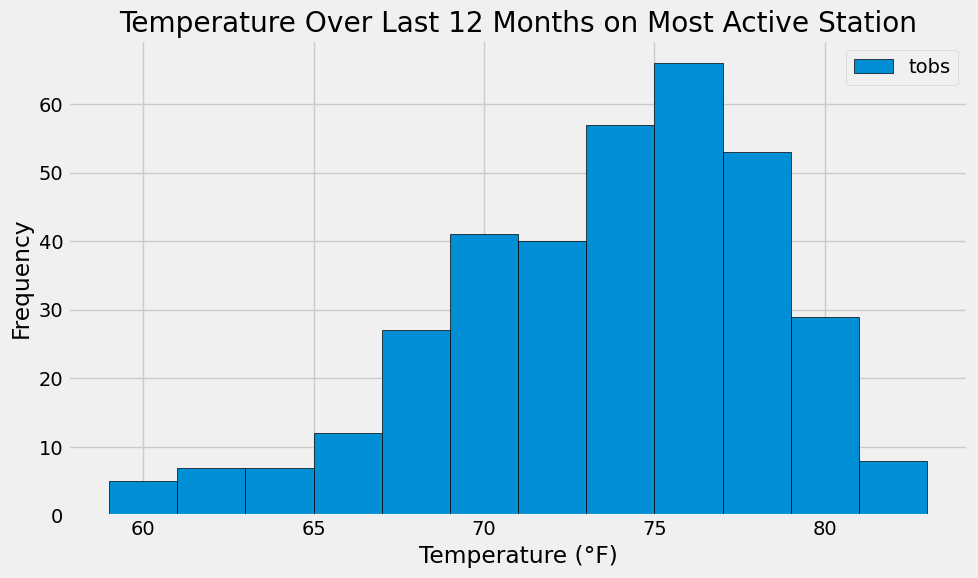

In [15]:
# Using the most active station id
most_active_station = station_counts[0][0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
most_active_station_df = pd.DataFrame(most_active_station_data, columns=['Date', 'Temperature'])

# List of temperatures
temperatures = most_active_station_df['Temperature']

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, edgecolor='black', label='tobs')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Over Last 12 Months on Most Active Station')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


# Close Session

In [16]:
# Close Session
session.close()